### Alex Jurcich

### Homework 2 Problem 2

For this assignment I will be pedicting the weather using different features related to weather.

Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# **Question 1**

Import Data

In [2]:
df = pd.read_csv('weather_classification_data.csv')
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Identify Feature Types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


Looking at the data we see that we have 7 continuous features and 4 categorical features.

**Continuous Features:**

Temperature, Humidity, Wind Speed, Precipitation (%), Atmospheric Pressure, UV Index, Visibility (km)

**Categorical Features:**

Cloud Cover, Season, Location, Weather Type

Data Statistics

In [4]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


Check for missing data

In [5]:
df.isnull().sum()

,0
Temperature,0
Humidity,0
Wind Speed,0
Precipitation (%),0
Cloud Cover,0
Atmospheric Pressure,0
UV Index,0
Season,0
Visibility (km),0
Location,0


Feature Distributions

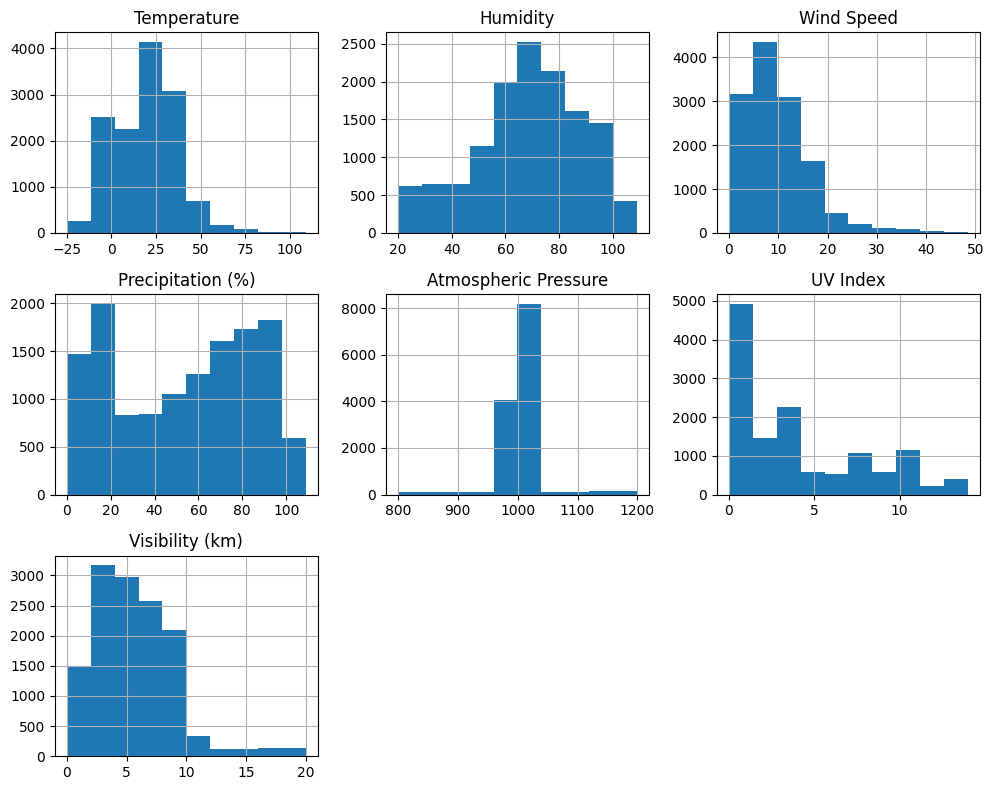

In [6]:
df.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

Looking at the distributions of the Continuous Features. Removing outliers using IQR could help normalize Visibility, and Atmospheric Pressure.

In [7]:
df.shape

(13200, 11)

Remove Outliers using IQR For Atmospheric Pressure

In [8]:
Q1 = df['Atmospheric Pressure'].quantile(0.25)
Q3 = df['Atmospheric Pressure'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Atmospheric Pressure'] >= lower_bound) & (df['Atmospheric Pressure'] <= upper_bound)]

Distribution Plots after IQR

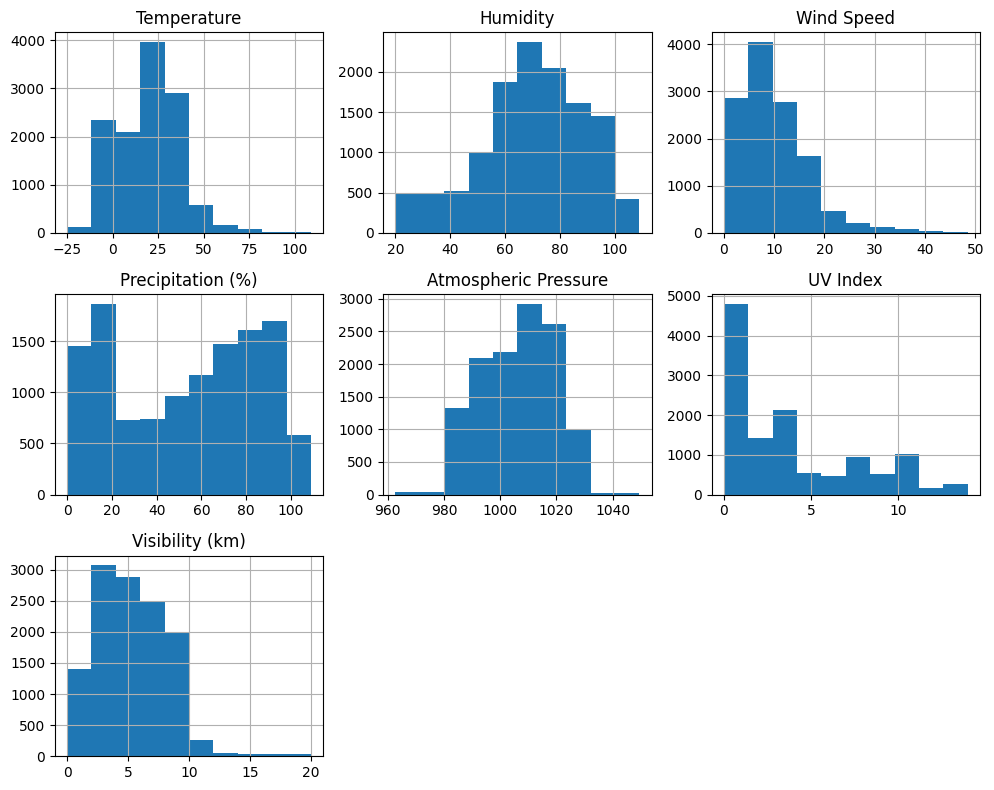

In [9]:
df.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

After removing the outliers the data is better distributed, which is better for our models

Categorical Data Distributions

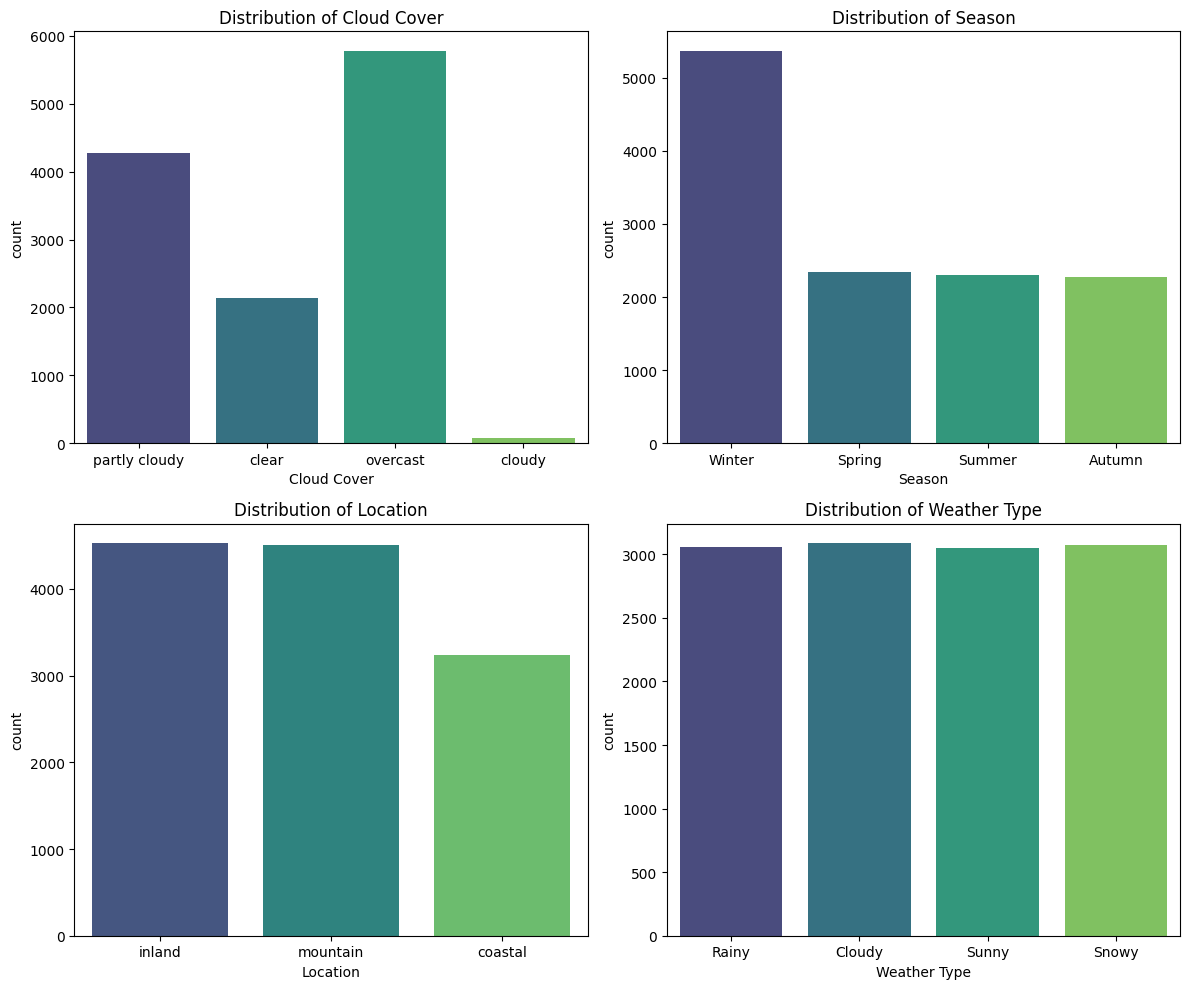

In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col, hue=col, legend=False, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

The Distributions for the Categorical features are evenly distibuted, except for Cloud Cover, but no treatmnet is needed.

One-Hot Encoding

In [11]:
# Cloud Cover
cloud_cover_labels = ['clear', 'partly cloudy', 'overcast', 'cloudy']
cloud_encoder = LabelEncoder()
cloud_encoder.fit(cloud_cover_labels)
df['Cloud Cover'] = cloud_encoder.transform(df['Cloud Cover'])

# Location
location_labels = ['inland', 'mountain', 'coastal']
location_encoder = LabelEncoder()
location_encoder.fit(location_labels)
df['Location'] = location_encoder.transform(df['Location'])

# Season
season_labels = ['Spring', 'Summer', 'Autumn', 'Winter']
season_encoder = LabelEncoder()
season_encoder.fit(season_labels)
df['Season'] = season_encoder.transform(df['Season'])

# Weather Type
weather_type_labels = ['Sunny', 'Cloudy', 'Rainy', 'Snowy']
weather_type_encoder = LabelEncoder()
weather_type_encoder.fit(weather_type_labels)
df['Weather Type'] = weather_type_encoder.transform(df['Weather Type'])

df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,3,1010.82,2,3,3.5,1,1
1,39.0,96,8.5,71.0,3,1011.43,7,1,10.0,1,0
2,30.0,64,7.0,16.0,0,1018.72,5,1,5.5,2,3
3,38.0,83,1.5,82.0,0,1026.25,7,1,1.0,0,3
4,27.0,74,17.0,66.0,2,990.67,1,3,2.5,2,1


Final Check of Data Types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12273 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           12273 non-null  float64
 1   Humidity              12273 non-null  int64  
 2   Wind Speed            12273 non-null  float64
 3   Precipitation (%)     12273 non-null  float64
 4   Cloud Cover           12273 non-null  int64  
 5   Atmospheric Pressure  12273 non-null  float64
 6   UV Index              12273 non-null  int64  
 7   Season                12273 non-null  int64  
 8   Visibility (km)       12273 non-null  float64
 9   Location              12273 non-null  int64  
 10  Weather Type          12273 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 1.1 MB


# **Question 2**

Correlation mattrix

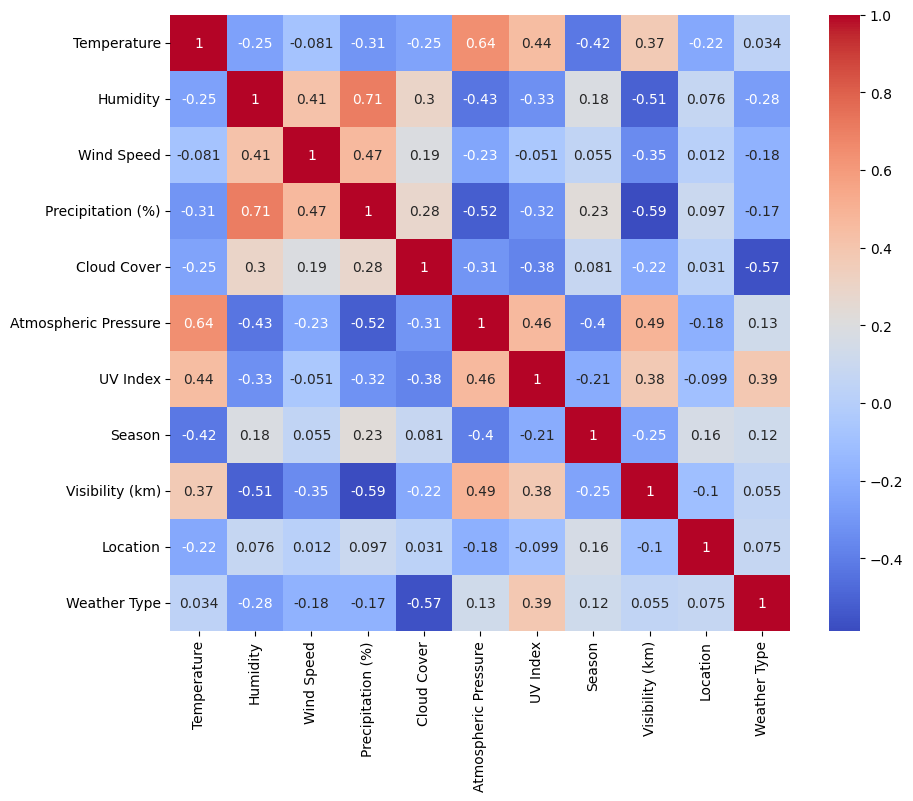

In [13]:
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

Scatter Plots

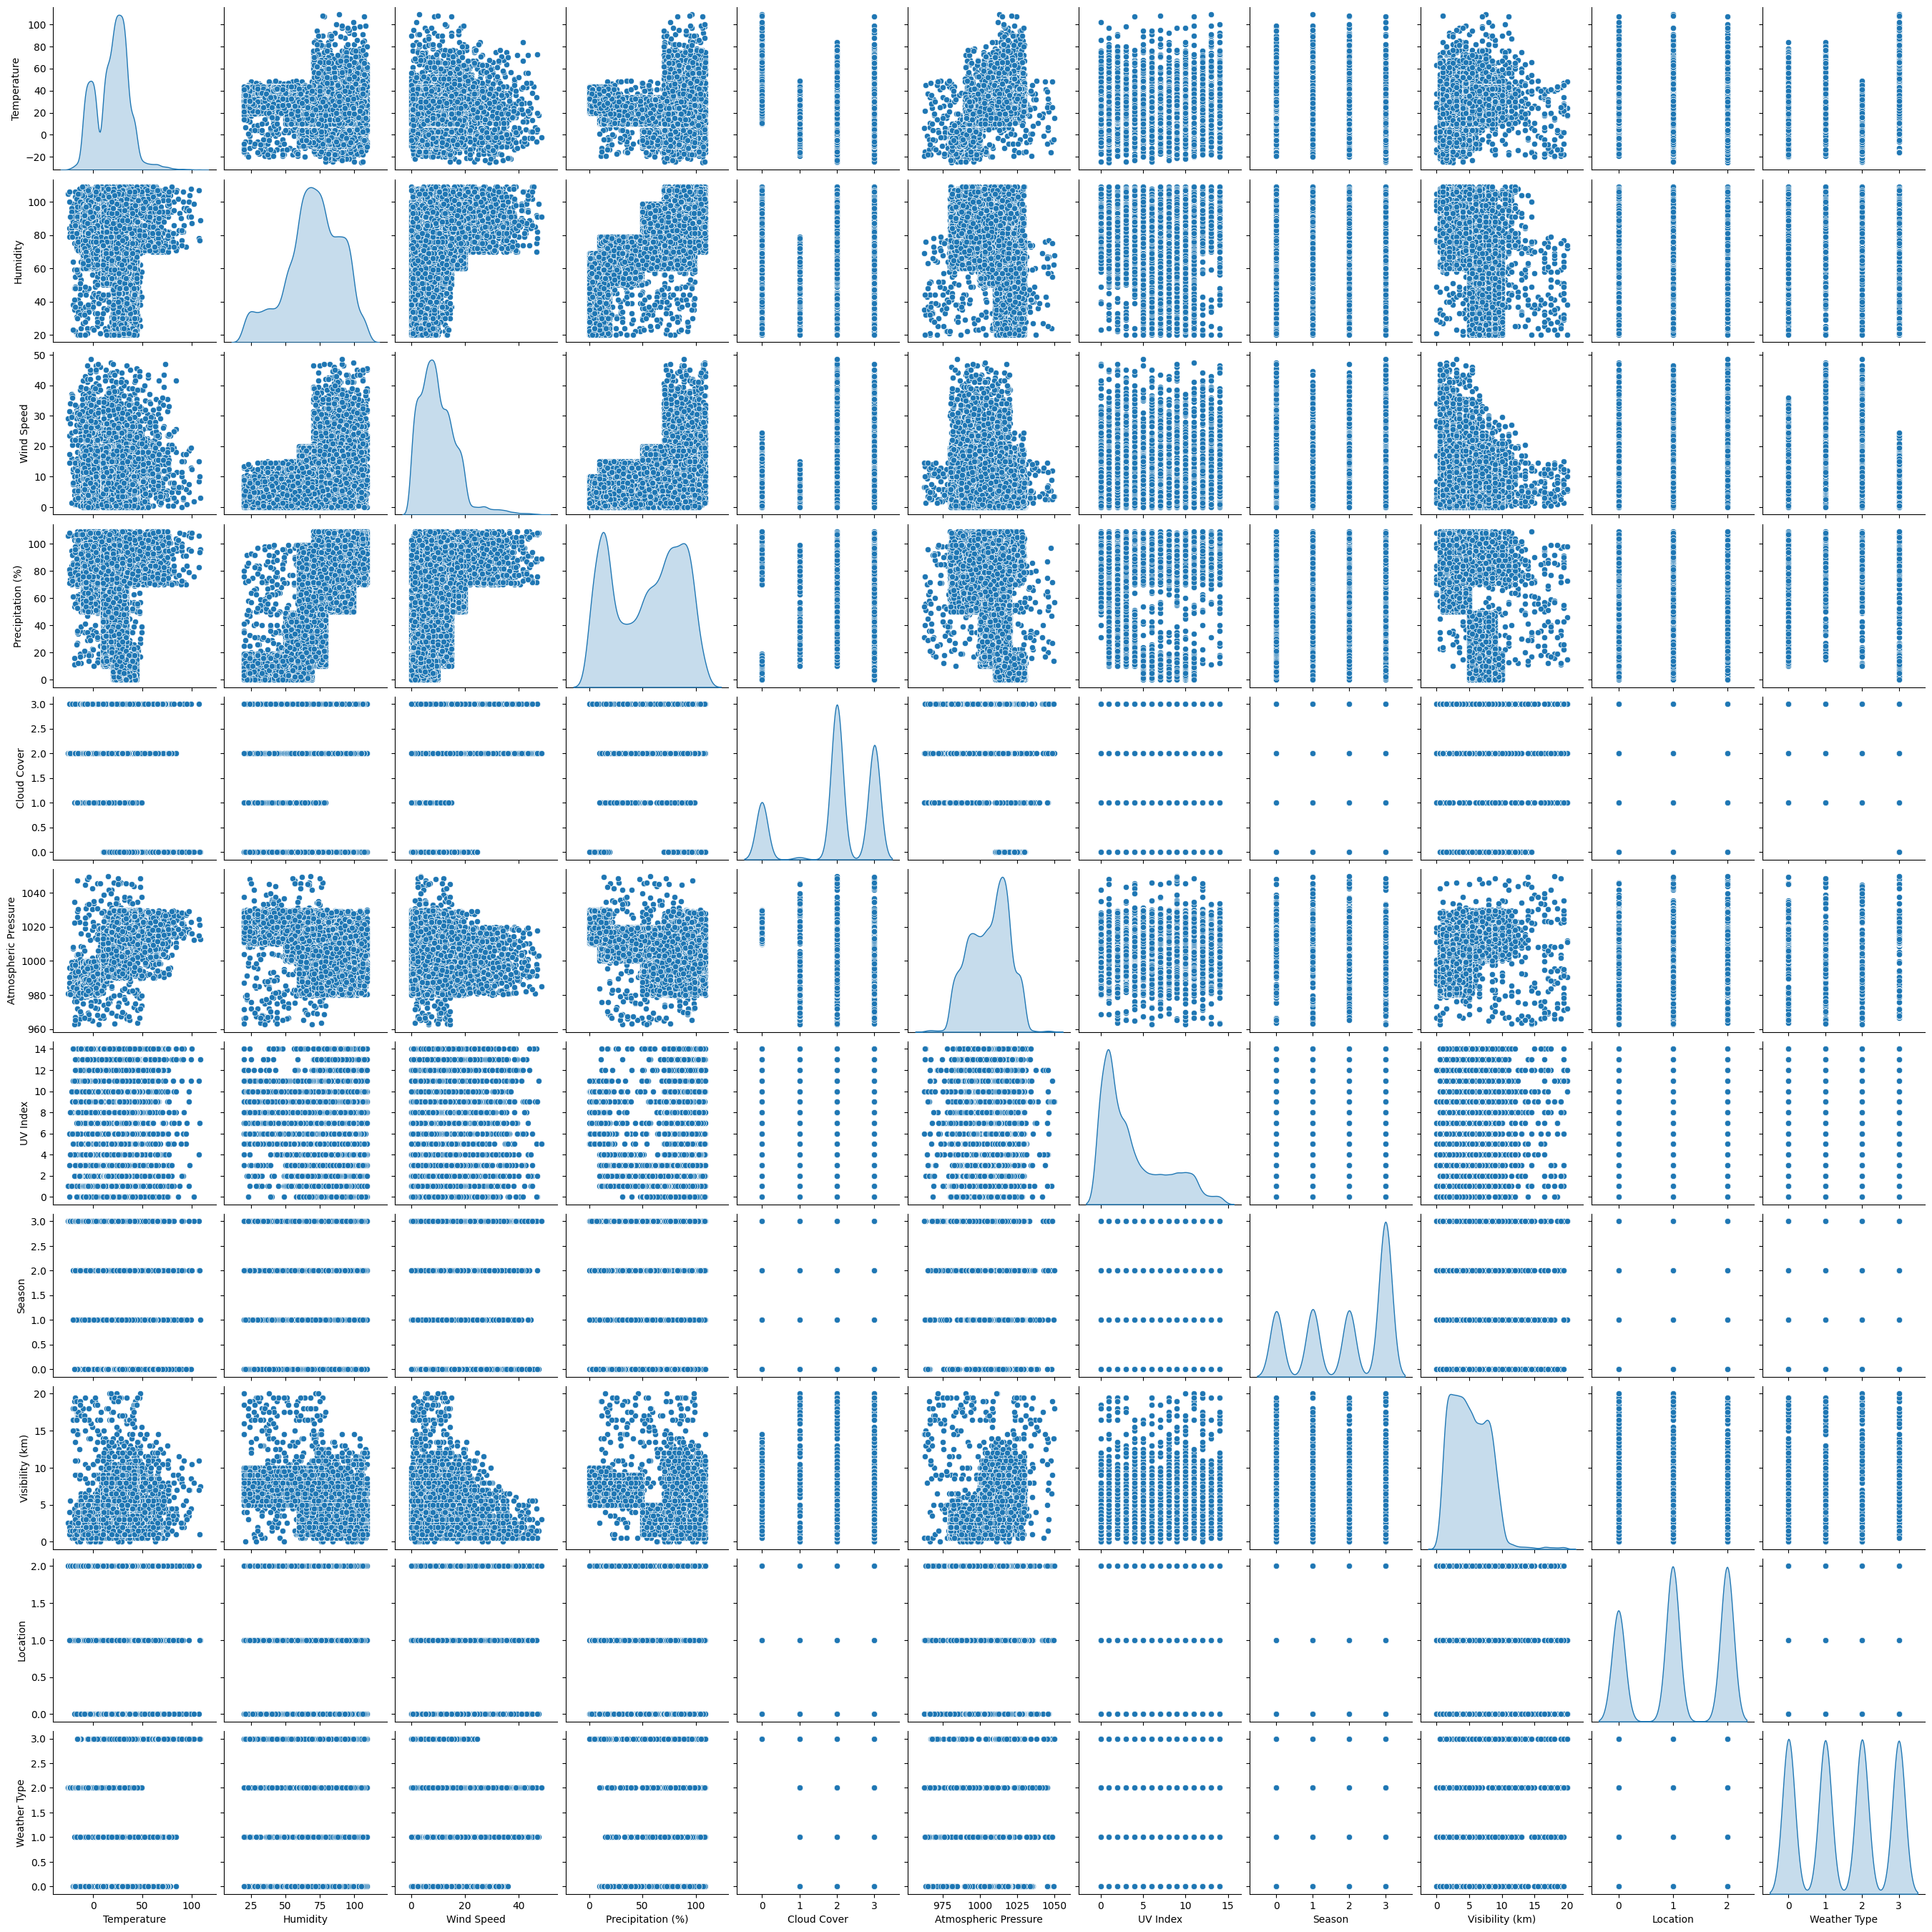

In [14]:
scatter = sns.pairplot(df, diag_kind='kde')
plt.show()

Correlation to Weather Type

In [15]:
corr_matrix['Weather Type'].sort_values(ascending=False)

,Weather Type
Weather Type,1.000000
UV Index,0.385049
Atmospheric Pressure,0.129080
Season,0.124698
Location,0.074707
Visibility (km),0.054580
Temperature,0.034184
Precipitation (%),-0.171238
Wind Speed,-0.176290
Humidity,-0.275156


# **Question 3**

Split data

In [16]:
X = df.drop('Weather Type', axis=1)
y = df['Weather Type']

# 70% for training
train_X, X_temp, train_y, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split remaining 30% for Val and Test
val_X, test_X, val_y, test_y = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verification
print("Training set shape:", train_X.shape, train_y.shape)
print("Validation set shape:", val_X.shape, val_y.shape)
print("Test set shape:", test_X.shape, test_y.shape)

print("\nClass distribution in original data:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(train_y.value_counts(normalize=True))

print("\nClass distribution in validation set:")
print(val_y.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(test_y.value_counts(normalize=True))

Training set shape: (8591, 10) (8591,)
Validation set shape: (1841, 10) (1841,)
Test set shape: (1841, 10) (1841,)

Class distribution in original data:
Weather Type
0    0.251446
2    0.250631
1    0.249328
3    0.248594
Name: proportion, dtype: float64

Class distribution in training set:
Weather Type
3    0.252474
0    0.249447
1    0.249331
2    0.248749
Name: proportion, dtype: float64

Class distribution in validation set:
Weather Type
0    0.268876
1    0.247148
2    0.245519
3    0.238457
Name: proportion, dtype: float64

Class distribution in test set:
Weather Type
2    0.264530
1    0.251494
0    0.243346
3    0.240630
Name: proportion, dtype: float64


Overall each of the Weather Types are ~25% thus we can say that the split gives a reasonable represention of the whole data set.

# **Question 4**

## Softmax Regression

Define Parameters for Grid Search

In [141]:
parameters = {
    'C': [1],
    'max_iter': [500],
    'solver': ['saga']
}

Create Softmax Model

In [142]:
softmax = LogisticRegression(multi_class='multinomial')

Grid Search

In [143]:
grid_search = GridSearchCV(
    estimator=softmax,
    param_grid=parameters,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(train_X, train_y)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 1, 'max_iter': 500, 'solver': 'saga'}


To reduce the running time, I narrowed the grid search to the best parameters after testing smaller and larger values for each variable.

Fit model with best parameters

In [145]:
best_model = grid_search.best_estimator_

# Fit
best_model.fit(train_X, train_y)

# Predictions
train_pred = best_model.predict(train_X)

# Scores
train_accuracy = accuracy_score(train_y, train_pred)
train_precision = precision_score(train_y, train_pred, average='weighted')
train_recall = recall_score(train_y, train_pred, average='weighted')
train_f1 = f1_score(train_y, train_pred, average='weighted')

print("Training Data Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nDetailed Classification Report for Training Data:")
print(classification_report(train_y, train_pred))

Training Data Performance:
Accuracy: 0.9277
Precision: 0.9280
Recall: 0.9277
F1 Score: 0.9276

Detailed Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2143
           1       0.90      0.94      0.92      2142
           2       0.98      0.98      0.98      2137
           3       0.94      0.90      0.92      2169

    accuracy                           0.93      8591
   macro avg       0.93      0.93      0.93      8591
weighted avg       0.93      0.93      0.93      8591



Run on Val Set

In [146]:
# Predictions
val_pred = best_model.predict(val_X)

# Scores
val_accuracy = accuracy_score(val_y, val_pred)
val_precision = precision_score(val_y, val_pred, average='weighted')
val_recall = recall_score(val_y, val_pred, average='weighted')
val_f1 = f1_score(val_y, val_pred, average='weighted')

print("Val Data Performance:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print("\nDetailed Classification Report for Val Data:")
print(classification_report(val_y, val_pred))

Val Data Performance:
Accuracy: 0.9278
Precision: 0.9283
Recall: 0.9278
F1 Score: 0.9277

Detailed Classification Report for Val Data:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       495
           1       0.89      0.95      0.92       455
           2       0.98      0.98      0.98       452
           3       0.92      0.89      0.90       439

    accuracy                           0.93      1841
   macro avg       0.93      0.93      0.93      1841
weighted avg       0.93      0.93      0.93      1841



Run on Test Set

In [147]:
# Predictions
val_pred = best_model.predict(val_X)

# Scores
val_accuracy = accuracy_score(val_y, val_pred)
val_precision = precision_score(val_y, val_pred, average='weighted')
val_recall = recall_score(val_y, val_pred, average='weighted')
val_f1 = f1_score(val_y, val_pred, average='weighted')

print("Val Data Performance:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print("\nDetailed Classification Report for Val Data:")
print(classification_report(val_y, val_pred))

Val Data Performance:
Accuracy: 0.9278
Precision: 0.9283
Recall: 0.9278
F1 Score: 0.9277

Detailed Classification Report for Val Data:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       495
           1       0.89      0.95      0.92       455
           2       0.98      0.98      0.98       452
           3       0.92      0.89      0.90       439

    accuracy                           0.93      1841
   macro avg       0.93      0.93      0.93      1841
weighted avg       0.93      0.93      0.93      1841



### Summary

Softmax had an accuracy of 92.77% on the training data and 92.77% on the test data, with precision, recall, and F1-scores following a similar. The test set peformed exactly the same as the training set, which shows the model is performing very well. The hyperparameters used in the grid search were C and max_iter. C represents the regularization strength, where a higher C value can lead to overfitting, while a lower C can result in underfitting. Since the C value used in this model was 1. more regualrization isn't needed.



## SVM

Define parameters for grid search

In [148]:
parameters = {
    'svm__C': [1],
    'svm__kernel': ['rbf'],
    'svm__degree': [2],
    'svm__gamma': ['scale']
}

Create SVM Model

In [149]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

Grid Search

In [150]:
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=parameters,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(train_X, train_y)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


To reduce the running time, I narrowed the grid search to the best parameters after testing smaller and larger values for each variable.

Fit model with best parameters

In [151]:
best_model = grid_search.best_estimator_

# Fit
best_model.fit(train_X, train_y)

# Predictions
train_pred = best_model.predict(train_X)

# Scores
train_accuracy = accuracy_score(train_y, train_pred)
train_precision = precision_score(train_y, train_pred, average='weighted')
train_recall = recall_score(train_y, train_pred, average='weighted')
train_f1 = f1_score(train_y, train_pred, average='weighted')

print("Training Data Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nDetailed Classification Report for Training Data:")
print(classification_report(train_y, train_pred))

Training Data Performance:
Accuracy: 0.9735
Precision: 0.9736
Recall: 0.9735
F1 Score: 0.9735

Detailed Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2143
           1       0.96      0.98      0.97      2142
           2       0.99      0.99      0.99      2137
           3       0.99      0.97      0.98      2169

    accuracy                           0.97      8591
   macro avg       0.97      0.97      0.97      8591
weighted avg       0.97      0.97      0.97      8591



Run on Val Set

In [152]:
# Predictions
train_pred = best_model.predict(val_X)

# Scores
train_accuracy = accuracy_score(val_y, train_pred)
train_precision = precision_score(val_y, train_pred, average='weighted')
train_recall = recall_score(val_y, train_pred, average='weighted')
train_f1 = f1_score(val_y, train_pred, average='weighted')

print("Val Data Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nDetailed Classification Report for Val Data:")
print(classification_report(val_y, train_pred))

Val Data Performance:
Accuracy: 0.9658
Precision: 0.9658
Recall: 0.9658
F1 Score: 0.9657

Detailed Classification Report for Val Data:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       495
           1       0.95      0.96      0.96       455
           2       0.98      0.99      0.98       452
           3       0.97      0.96      0.97       439

    accuracy                           0.97      1841
   macro avg       0.97      0.97      0.97      1841
weighted avg       0.97      0.97      0.97      1841



Run on Test Set

In [153]:
# Predictions
train_pred = best_model.predict(test_X)

# Scores
train_accuracy = accuracy_score(test_y, train_pred)
train_precision = precision_score(test_y, train_pred, average='weighted')
train_recall = recall_score(test_y, train_pred, average='weighted')
train_f1 = f1_score(test_y, train_pred, average='weighted')

print("Test Data Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nDetailed Classification Report for Test Data:")
print(classification_report(test_y, train_pred))

Test Data Performance:
Accuracy: 0.9533
Precision: 0.9536
Recall: 0.9533
F1 Score: 0.9533

Detailed Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       448
           1       0.94      0.94      0.94       463
           2       0.97      0.99      0.98       487
           3       0.98      0.94      0.96       443

    accuracy                           0.95      1841
   macro avg       0.95      0.95      0.95      1841
weighted avg       0.95      0.95      0.95      1841



### Summary

The SVM model performed with an accuracy of 97.35% on the training data and 95.33% on the test data. The precision, recall, and F1-scores followed a similar trend across both datasets. The training set outperformed the training set, which may suggest slight overfitting on the training data.

The hyperparameters used in the grid search were C, degree, gamma, and kernel. C represents the regularization strength; a higher value of C can lead to overfitting, while a lower value can result in underfitting. Since the best C value was 1 and the test accuracy was slightly lower than the training accuracy, the model appears to be fitting well without overfitting or underfitting. The degree of the polynomial kernel was 2, and gamma was set to scale, using the rbf kernel type.

## Random Forests

Define parameters for grid search

In [18]:
parameters = {
    'n_estimators': [100],
    'max_depth': [12],
    'min_samples_split': [10],
    'min_samples_leaf': [5],
    'max_features': ['log2']
}

Create RF model

In [19]:
rdf_clf = RandomForestClassifier()

Grid Search

In [20]:
grid_search = GridSearchCV(
    estimator=rdf_clf,
    param_grid=parameters,
    scoring='accuracy',
    n_jobs=-1,
)

grid_search.fit(train_X, train_y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.9651952667610715


To reduce the running time, I narrowed the grid search to the best parameters after testing smaller and larger values for each variable.

Fit model with best parameters

In [21]:
best_model = grid_search.best_estimator_

# Fit
best_model.fit(train_X, train_y)

# Predictions
train_pred = best_model.predict(train_X)

# Scores
train_accuracy = accuracy_score(train_y, train_pred)
train_precision = precision_score(train_y, train_pred, average='weighted')
train_recall = recall_score(train_y, train_pred, average='weighted')
train_f1 = f1_score(train_y, train_pred, average='weighted')

print("Training Data Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nDetailed Classification Report for Training Data:")
print(classification_report(train_y, train_pred))

Training Data Performance:
Accuracy: 0.9830
Precision: 0.9831
Recall: 0.9830
F1 Score: 0.9830

Detailed Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2143
           1       0.98      0.98      0.98      2142
           2       1.00      0.99      0.99      2137
           3       0.99      0.98      0.99      2169

    accuracy                           0.98      8591
   macro avg       0.98      0.98      0.98      8591
weighted avg       0.98      0.98      0.98      8591



Run on Val Set

In [22]:
# Predictions
train_pred = best_model.predict(val_X)

# Scores
train_accuracy = accuracy_score(val_y, train_pred)
train_precision = precision_score(val_y, train_pred, average='weighted')
train_recall = recall_score(val_y, train_pred, average='weighted')
train_f1 = f1_score(val_y, train_pred, average='weighted')

print("Val Data Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nDetailed Classification Report for Val Data:")
print(classification_report(val_y, train_pred))

Val Data Performance:
Accuracy: 0.9696
Precision: 0.9697
Recall: 0.9696
F1 Score: 0.9696

Detailed Classification Report for Val Data:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       495
           1       0.97      0.96      0.96       455
           2       0.98      0.99      0.98       452
           3       0.99      0.97      0.98       439

    accuracy                           0.97      1841
   macro avg       0.97      0.97      0.97      1841
weighted avg       0.97      0.97      0.97      1841



Run on Test Set

In [23]:
# Predictions
train_pred = best_model.predict(test_X)

# Scores
train_accuracy = accuracy_score(test_y, train_pred)
train_precision = precision_score(test_y, train_pred, average='weighted')
train_recall = recall_score(test_y, train_pred, average='weighted')
train_f1 = f1_score(test_y, train_pred, average='weighted')

print("Test Data Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nDetailed Classification Report for Test Data:")
print(classification_report(test_y, train_pred))

Test Data Performance:
Accuracy: 0.9603
Precision: 0.9615
Recall: 0.9603
F1 Score: 0.9606

Detailed Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       448
           1       0.96      0.95      0.96       463
           2       0.99      0.98      0.98       487
           3       0.99      0.95      0.97       443

    accuracy                           0.96      1841
   macro avg       0.96      0.96      0.96      1841
weighted avg       0.96      0.96      0.96      1841



### Summary

The Random Forest model performed with an accuracy of 98.30% on the training data and 96.03% on the test data. The precision, recall, and F1-scores followed a similar trend across both datasets. The validation set outperformed the training set, which may suggest slight overfitting on the training data.
The hyperparameters used in the grid search were n_estimators. max_depth, min_sample_leaf, min_sample_split, and max_features.


# **Question 5**

Soft Voting

In [46]:
softmax = LogisticRegression(multi_class='multinomial', C=1, max_iter=500, solver='saga')

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1, degree=2, gamma='scale', kernel='rbf', probability=True))
])

random_forest = RandomForestClassifier(max_depth=12, min_samples_leaf=5,
                                       min_samples_split=10, n_estimators=100, max_features='log2',
                                       random_state=42)

voting_clf = VotingClassifier(
    estimators=[('soft', softmax), ('svm', svm_clf), ('rf', random_forest)],
    voting='soft',
    weights=[1,2,3]
)



models = [softmax, svm_clf, random_forest, voting_clf]
model_names = ['Softmax', 'SVM', 'Random Forest', 'Voting Ensemble']

for clf, name in zip(models, model_names):
    clf.fit(train_X, train_y)
    val_pred = clf.predict(val_X)
    val_accuracy = accuracy_score(val_y, val_pred)
    print(f"{name} Accuracy on Validation Set: {val_accuracy:.4f}")

Softmax Accuracy on Validation Set: 0.9278
SVM Accuracy on Validation Set: 0.9658
Random Forest Accuracy on Validation Set: 0.9701
Voting Ensemble Accuracy on Validation Set: 0.9674


Hard Voting

In [45]:
softmax = LogisticRegression(multi_class='multinomial', C=1, max_iter=500, solver='saga')

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1, degree=2, gamma='scale', kernel='rbf', probability=True))
])

random_forest = RandomForestClassifier(max_depth=12, min_samples_leaf=5,
                                       min_samples_split=10, n_estimators=100, max_features='log2',
                                       random_state=42)

voting_clf = VotingClassifier(
    estimators=[('soft', softmax), ('svm', svm_clf), ('rf', random_forest)],
    voting='hard',
    weights=[1,2,3]
)



models = [softmax, svm_clf, random_forest, voting_clf]
model_names = ['Softmax', 'SVM', 'Random Forest', 'Voting Ensemble']

for clf, name in zip(models, model_names):
    clf.fit(train_X, train_y)
    val_pred = clf.predict(val_X)
    val_accuracy = accuracy_score(val_y, val_pred)
    print(f"{name} Accuracy on Validation Set: {val_accuracy:.4f}")

Softmax Accuracy on Validation Set: 0.9278
SVM Accuracy on Validation Set: 0.9658
Random Forest Accuracy on Validation Set: 0.9701
Voting Ensemble Accuracy on Validation Set: 0.9707


Overall, from the results on our test set, we see that Random Forest and the ensamble performed tsimular same. After playing around with graident boosting, and changing the weights of each model 97.07% is a small increase from the random forest model.

We will use the Hard voting Ensemble on the Test Set

In [50]:
softmax = LogisticRegression(multi_class='multinomial', C=1, max_iter=500, solver='saga')

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1, degree=2, gamma='scale', kernel='rbf', probability=True))
])

random_forest = RandomForestClassifier(max_depth=12, min_samples_leaf=5,
                                       min_samples_split=10, n_estimators=100, max_features='log2',
                                       random_state=42)

voting_clf = VotingClassifier(
    estimators=[('soft', softmax), ('svm', svm_clf), ('rf', random_forest)],
    voting='hard',
    weights=[1,2,3]
)



models = [softmax, svm_clf, random_forest, voting_clf]
model_names = ['Softmax', 'SVM', 'Random Forest', 'Voting Ensemble']

for clf, name in zip(models, model_names):
    clf.fit(train_X, train_y)
    test_pred = clf.predict(test_X)
    test_accuracy = accuracy_score(test_y, test_pred)
    print(f"{name} Accuracy on Validation Set: {test_accuracy:.4f}")

Softmax Accuracy on Validation Set: 0.9196
SVM Accuracy on Validation Set: 0.9533
Random Forest Accuracy on Validation Set: 0.9565
Voting Ensemble Accuracy on Validation Set: 0.9549


Overall there was a slight loss when computing the Ensemble, but since the increase on the training data was minimal the decrease isn't a surprise.